# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/Earth1270/intro-to-ml-tensorflow/blob/WorkingCopy/projects/p2_image_classifier/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
# TODO: Make all necessary imports.

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'
import time

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import json as json
import glob
import os
from PIL import Image

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('Using:')
print('\t\u2022 Tensorflow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')


Using:
	• Tensorflow version: 2.8.0
	• tf.keras version: 2.8.0
	• Running on GPU


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [2]:
# TODO: Load the dataset with TensorFlow Datasets.
data, metadata = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

# TODO: Create a training set, a validation set and a test set.
print("\nType of data object: ", type(data), "\nType of metadata object:", type(metadata))
train, test, validate = data['train'], data['test'], data['validation']
print("\nType of train object: ", type(train))
print("\nMetadata summary: ", metadata)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete7TPWYM/oxford_flowers102-train.tfrecord


  0%|          | 0/1020 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete7TPWYM/oxford_flowers102-test.tfrecord


  0%|          | 0/6149 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete7TPWYM/oxford_flowers102-validation.tfrecord


  0%|          | 0/1020 [00:00<?, ? examples/s]

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.

Type of data object:  <class 'dict'> 
Type of metadata object: <class 'tensorflow_datasets.core.dataset_info.DatasetInfo'>

Type of train object:  <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>

Metadata summary:  tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set cons

## Explore the Dataset

In [3]:
# TODO: Get the number of examples in each set from the dataset info.
train_size, test_size, validate_size = metadata.splits['train'].num_examples, metadata.splits['test'].num_examples, metadata.splits['validation'].num_examples
print('\nDataset Types:')
print('\t\u2022Train: ', type(train), '\n\t\u2022Features: ', type(metadata.features['label']))
print('\nDataset Sizes:')
print('\t\u2022Training: ', train_size, '\n\t\u2022Testing: ', test_size, '\n\t\u2022Validation: ', validate_size)

# TODO: Get the number of classes in the dataset from the dataset info.
classes = metadata.features['label'].num_classes
print('\nNumber of Classes: ', classes)


Dataset Types:
	•Train:  <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'> 
	•Features:  <class 'tensorflow_datasets.core.features.class_label_feature.ClassLabel'>

Dataset Sizes:
	•Training:  1020 
	•Testing:  6149 
	•Validation:  1020

Number of Classes:  102


In [4]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
n=1
for image, label in train.take(3):
  print('\nShape and Label for Image {}:'.format(n))
  print('\t\u2022Shape: {}'.format(image.shape))
  print('\t\u2022Label: {}'.format(label))
  n +=1


Shape and Label for Image 1:
	•Shape: (500, 667, 3)
	•Label: 72

Shape and Label for Image 2:
	•Shape: (500, 666, 3)
	•Label: 84

Shape and Label for Image 3:
	•Shape: (670, 500, 3)
	•Label: 70


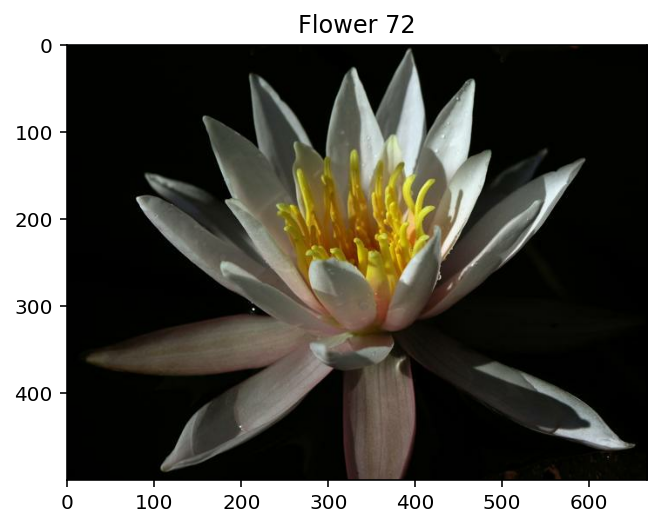

In [5]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
for image, label in train.take(1):
  ttl = "Flower " + str(label.numpy())
  plt.imshow(image)
  plt.title(ttl)
  plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [6]:
from google.colab import drive
drive.mount('/content/drive')
#!ls
#!pwd

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/Colab Notebooks
#!ls

/content/drive/MyDrive/Colab Notebooks


In [8]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

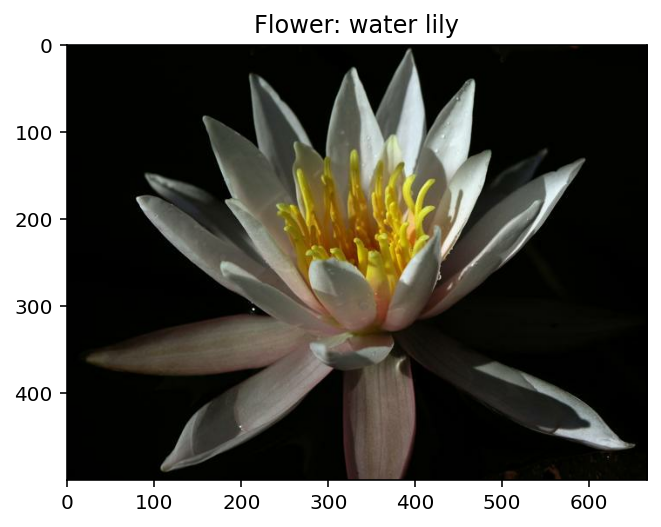

In [9]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
#per mentor notes, add 1 to reconcile coding

for image, label in train.take(1):
  ttl = "Flower: " + class_names[str(label.numpy()+1)]
  plt.imshow(image)
  plt.title(ttl)
  plt.show()

## Create Pipeline

In [10]:
# TODO: Create a pipeline for each set.

IMG = 224 #image size
BATCH = 32 #batch size

def normalize_input(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG, IMG))
  image /= 255
  return image, label

train_batch = train.shuffle(train_size//4).map(normalize_input).batch(BATCH).prefetch(1)
validation_batch = validate.map(normalize_input).batch(BATCH).prefetch(1)
test_batch = test.map(normalize_input).batch(BATCH).prefetch(1)

for image_batch, label_batch in train_batch.take(1):
  print('\nShape of training image and label batches:')
  print('\t\u2022Image batches:{}'.format(image_batch.shape))
  print('\t\u2022Label batches: {}'.format(label_batch.shape))


Shape of training image and label batches:
	•Image batches:(32, 224, 224, 3)
	•Label batches: (32,)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [11]:
# TODO: Build and train your network.
#List url, define feature_extractor with input shape
url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(url, input_shape=(IMG, IMG, 3))
feature_extractor_trainable=False

In [12]:
#Build Sequential model with extractor, softmax activation, and print summary
#output 102 nodes corresponding to count in class_names
model = tf.keras.Sequential([feature_extractor,
                             tf.keras.layers.Dense(classes, activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
#Use optimizer, loss function, and metric per class example:

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

#Use 20 epochs, eliminate callbacks
EPOCHS = 20
#shift metric to accuracy 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience = 7,
                                                  #mode='max',
                                                  #min_delta=1
                                                  )
#Add interim model saves:
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                               monitor='val_accuracy',
                                               mode='max',
                                               verbose=1,
                                               save_best_only=True)
#note that best model is saved as practice but not used
#below the last model is saved and reloaded per project directions

In [14]:
#Fit the model
history = model.fit(train_batch, 
                    epochs=EPOCHS,
                    validation_data = validation_batch,
                    #callbacks=[early_stopping]
                    ) 
#apply both early_stopping and best model save; stops after 20 epochs of 50
#remove save_best - does it impact history file?
#remove early stopping

Epoch 1/20
32/32 [==============================] - 21s 261ms/step - loss: 4.2927 - accuracy: 0.1265 - val_loss: 3.1535 - val_accuracy: 0.3745
Epoch 2/20
32/32 [==============================] - 8s 232ms/step - loss: 2.1018 - accuracy: 0.6706 - val_loss: 2.0432 - val_accuracy: 0.6431
Epoch 3/20
32/32 [==============================] - 8s 232ms/step - loss: 1.1143 - accuracy: 0.8951 - val_loss: 1.5659 - val_accuracy: 0.7265
Epoch 4/20
32/32 [==============================] - 8s 231ms/step - loss: 0.6803 - accuracy: 0.9598 - val_loss: 1.3107 - val_accuracy: 0.7637
Epoch 5/20
32/32 [==============================] - 8s 232ms/step - loss: 0.4475 - accuracy: 0.9863 - val_loss: 1.1755 - val_accuracy: 0.7755
Epoch 6/20
32/32 [==============================] - 8s 232ms/step - loss: 0.3198 - accuracy: 0.9951 - val_loss: 1.0785 - val_accuracy: 0.7961
Epoch 7/20
32/32 [==============================] - 8s 234ms/step - loss: 0.2391 - accuracy: 0.9980 - val_loss: 1.0146 - val_accuracy: 0.7951
Epoch

**Latest Model Questions**   
Does this model already contain dropout and augmentation? If not should I test?  
Something is definitely wrong now with model and history; note loss now at .96 for test even while accuracy has improved
Test later without early stop and save-best

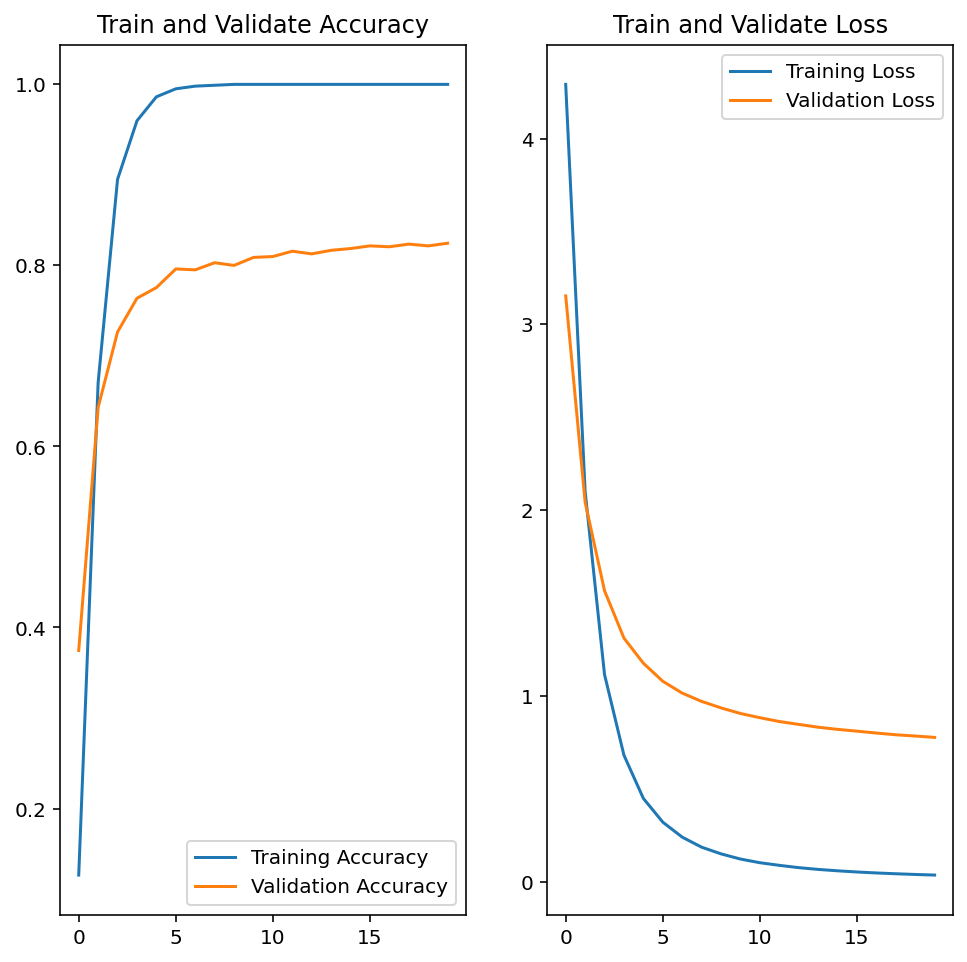

In [15]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
#Plots per class example, Part 5 Inference and Validation
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(len(training_accuracy)) 
#use training_accuracy lengths rather than EPOCHS since applying early_stopping

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, training_accuracy, label="Training Accuracy")
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Validate Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Train and Validate Loss')
plt.show()



## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = model.evaluate(test_batch)
print('\nTest Data Loss and Accuracy:')
print('\t\u2022Loss: {:,.4f}'.format(loss))
print("\t\u2022Accuracy: {:.2%}".format(accuracy))

193/193 [==============================] - 24s 122ms/step - loss: 0.9058 - accuracy: 0.7801

Test Data Loss and Accuracy:
	•Loss: 0.9058
	•Accuracy: 78.01%


**Latest Model Questions**

**Augmentation**
Further augmentation is not required since the accuracy on test data is greater than 70%

## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [17]:
# TODO: Save your trained model as a Keras model.
#save in a folder with time stamp on google drive
import time
t = time.time()

#SavedModels format:
Saved_Model = './{}.h5'.format(int(t))
#apply save method from error note on reload/predict
tf.keras.models.save_model(model, Saved_Model)

#save directory name to file:
text_file = open("file_name.txt", "w")
text_file.write(str(int(t)))
text_file.close()


In [21]:
print(type(Saved_Model))
print(Saved_Model)
print(text_file)

<class 'str'>
./1649449505.h5
<_io.TextIOWrapper name='file_name.txt' mode='w' encoding='UTF-8'>


## Load the Keras Model

Load the Keras model you saved above.

In [19]:
# TODO: Load the Keras model
#loaded_model = tf.keras.models.load_model(saved_path, custom_objects = {'KerasLayer':hub.KerasLayer})

#Using method from mentor help (https://knowledge.udacity.com/questions/818097)
Reloaded_Saved_Model = tf.keras.models.load_model(Saved_Model, custom_objects = {'KerasLayer':hub.KerasLayer})

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [22]:
# TODO: Create the process_image function
def process_image(image):
  image=tf.convert_to_tensor(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMG, IMG))
  image /= 255
  return image.numpy()

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

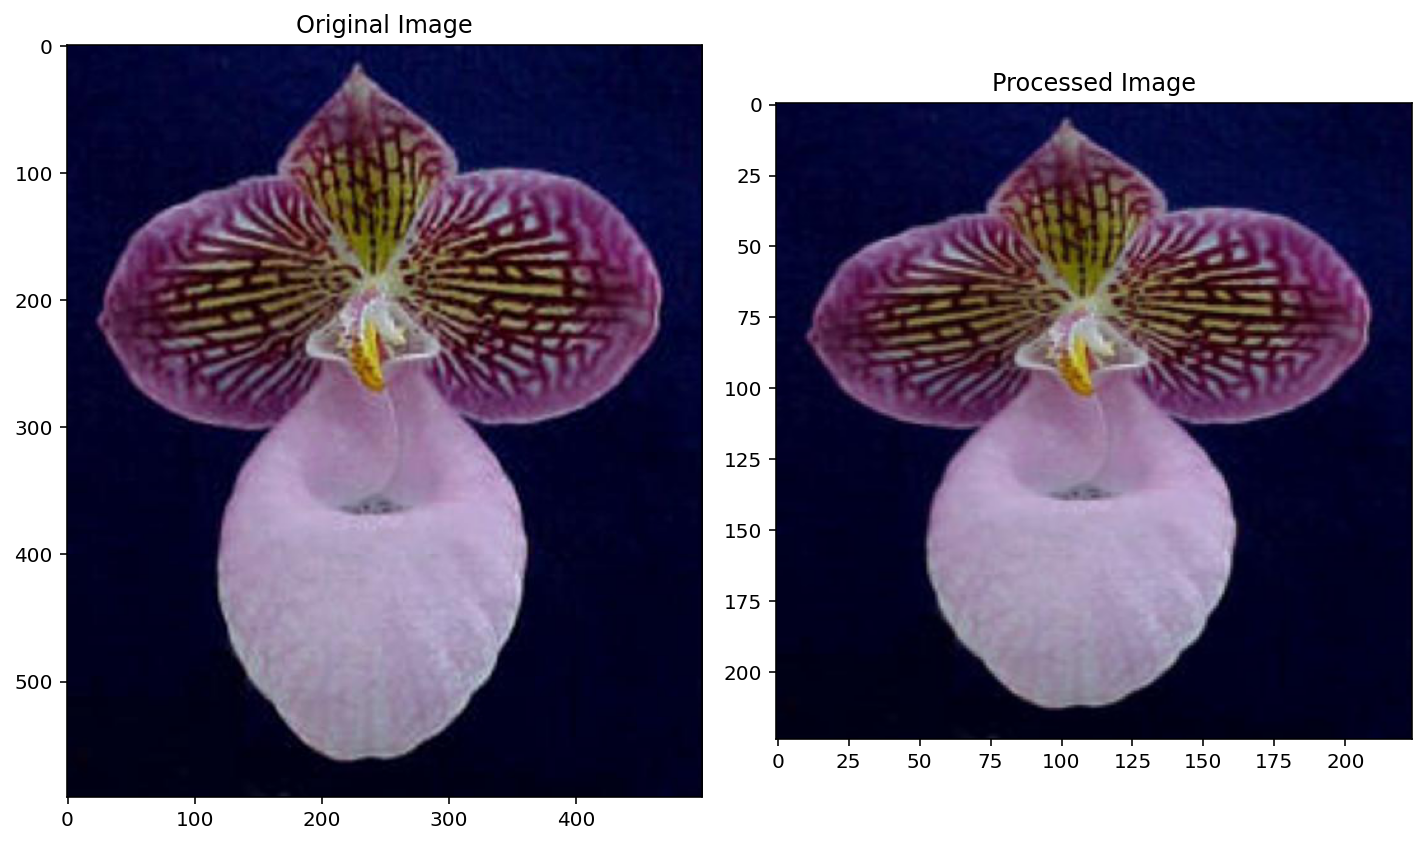

In [23]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [50]:
# TODO: Create the predict function

def predict(image, model, top_k):
  image = np.asarray(image)
  image = process_image(image)
  image_extra_dim = np.expand_dims(image, axis=0)
  #print("Image shape: ", image_extra_dim.shape)
  y_pred = model.predict(image_extra_dim)
  
  #method from stack overflow: https://stackoverflow.com/questions/50640687/get-top-k-predictions-from-tensorflow
  top_k_values, top_k_indices = tf.nn.top_k(y_pred, k=top_k)
  top_k_indices = 1 + top_k_indices[0] #add 1 to index, per mentor help
    
  return top_k_values.numpy()[0], top_k_indices.numpy().astype(str), image

#Predict is not correctly predicting

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='https://github.com/Earth1270/intro-to-ml-tensorflow/blob/WorkingCopy/projects/p2_image_classifier/assets/inference_example.png?raw=1' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [52]:
def label_class(classes):
  class_label = []
  for num_class in classes:
    class_label.append(class_names[str(int(num_class))].title())
  return class_label

In [ ]:
#to reload model using a filename stored as a string in a file
def Second_Model_Load(): 
  %cd /content/drive/MyDrive/Colab Notebooks 
  with open('file_name.txt', 'r') as f:
    file_name = f.readlines()
  model_path = file_name + '.txt'
  model = tf.keras.models.load_model(model_path, custom_objects = {'KerasLayer':hub.KerasLayer})
  return model

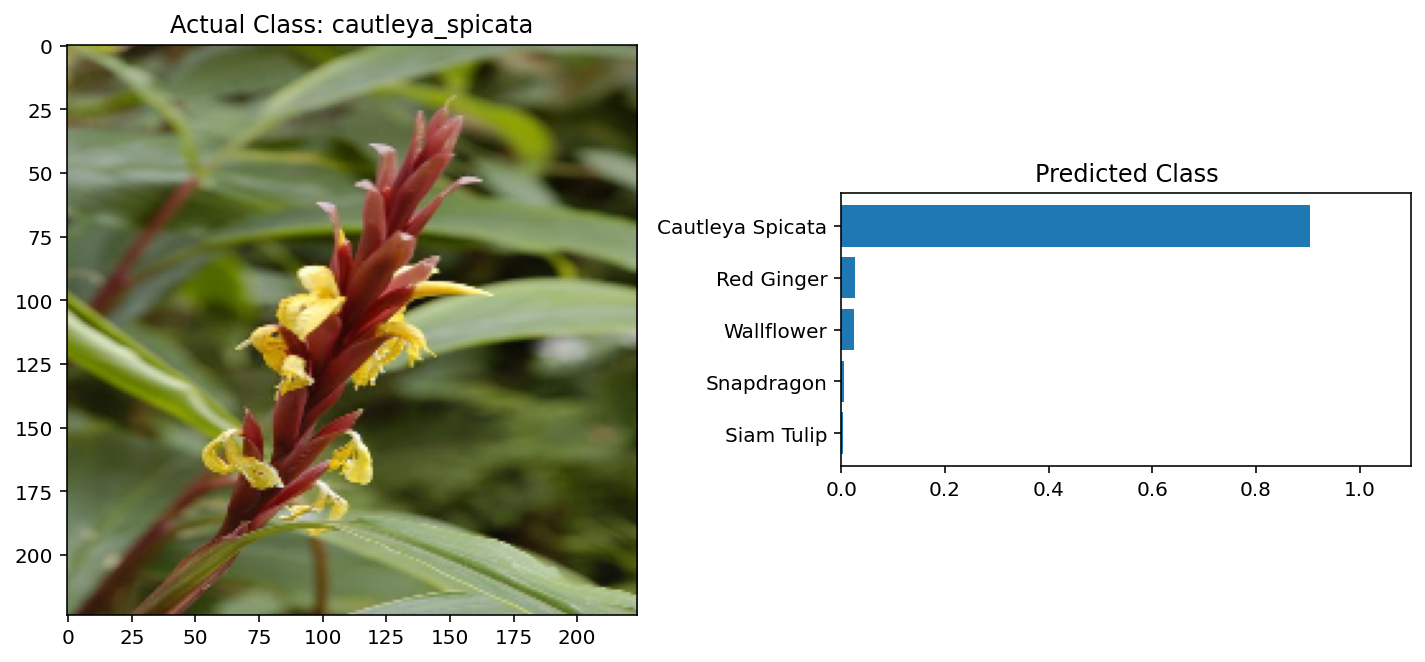

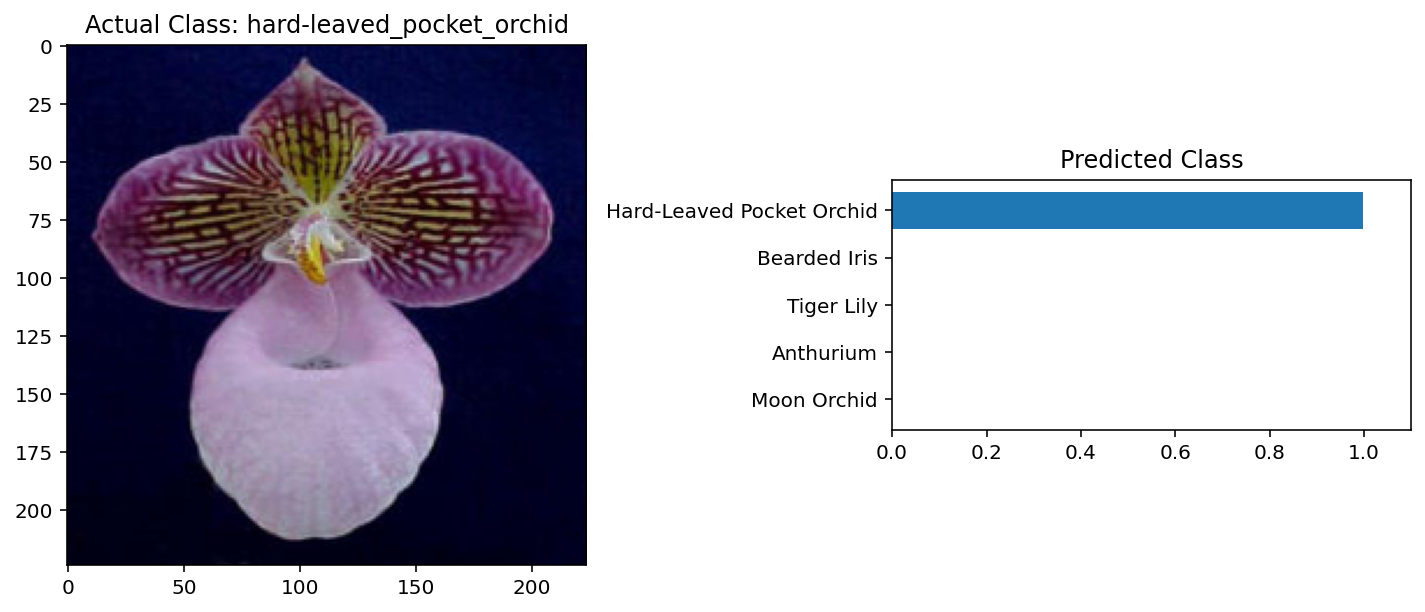

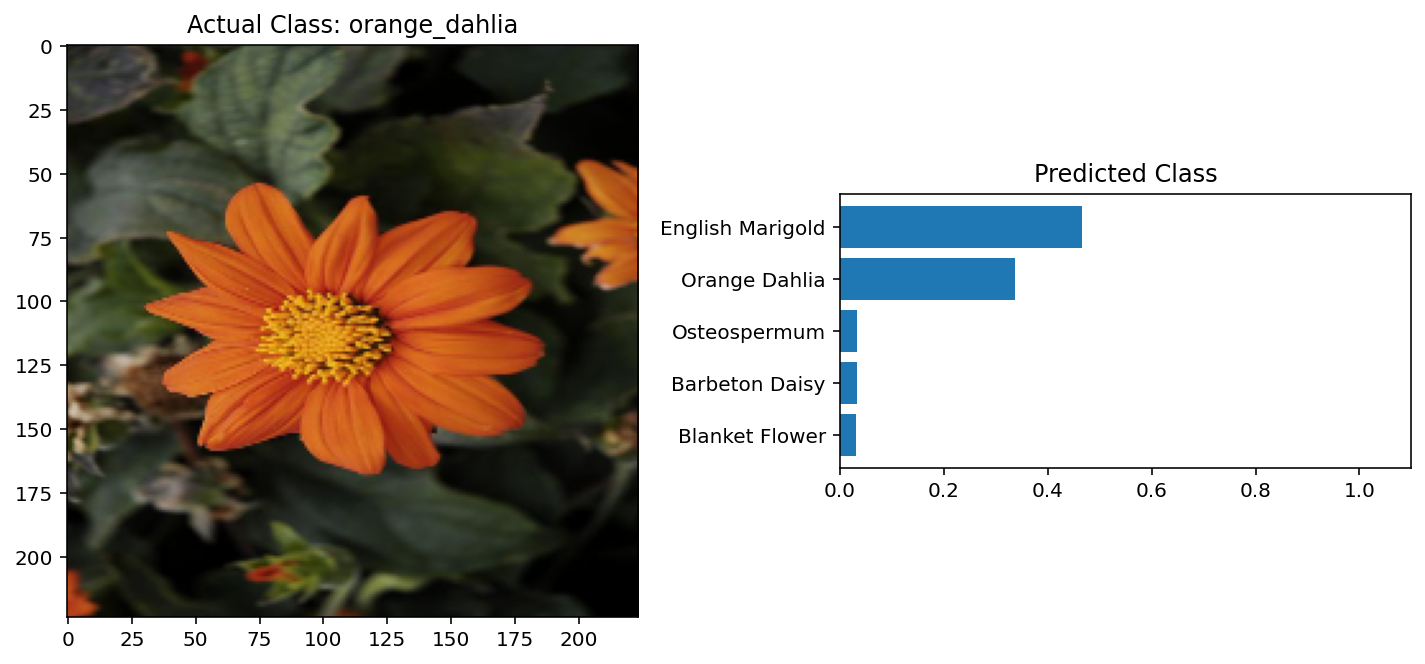

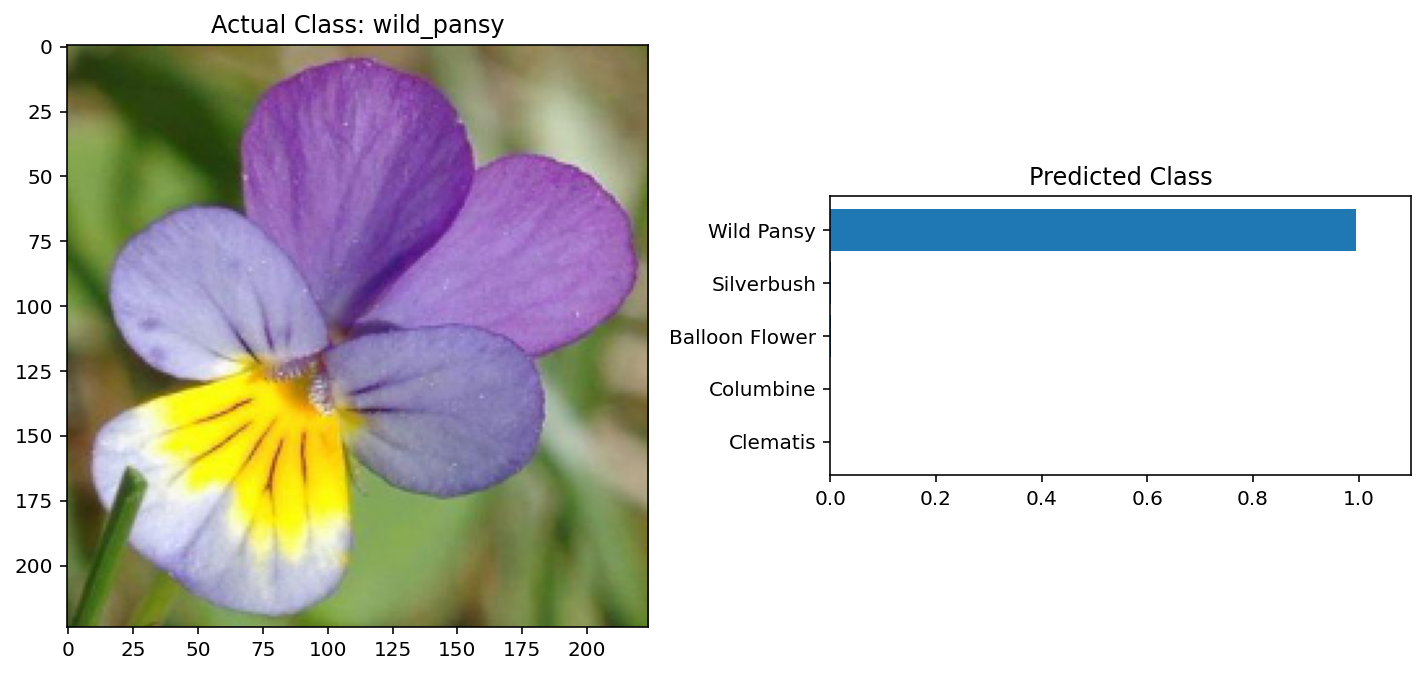

In [67]:
# TODO: Plot the input image along with the top 5 classes

#Use Reloaded_Saved_Model, model, Second_Model_Load()
test_model = model

image_list = glob.glob("./test_images/*.jpg")
for image in image_list:
  im = Image.open(image)
  #test_image = np.asarray(im)
  #run predict to find top k probabilities, classes for images
  probs, classes, processed_test_image = predict(im, test_model, 5)
  #assign the name to each class number using class_names
  class_label = label_class(classes)

#Sort the labels by probability for bar chart
  unsorted_list = [(probs, class_label) for class_label, probs in 
                  zip(class_label, probs)]
  sorted_list = sorted(unsorted_list)

  labels_sorted = []
  probs_sorted = []

  for i in sorted_list:
    labels_sorted += [i[1]]
    probs_sorted += [i[0]]

#plot processed image, sorted bar chart
  fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
  ax1.imshow(processed_test_image)
  #Label processed image with name from file name
  ax1.set_title("Actual Class: " + os.path.splitext(os.path.basename(image))[0])
  ax2.barh(labels_sorted, probs_sorted)
  #ax2.bar_label()
  ax2.set_aspect(0.1)
  ax2.set_xlim(0, 1.1)
  ax2.set_title('Predicted Class')
  plt.tight_layout()
  plt.show()

  #clearly not getting good predictions